In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
# import os
# os.environ["QISKIT_IN_PARALLEL"] = 'TRUE'

In [5]:
import numpy as np

In [12]:
cr_strengths = {"XZ": -0.643e-3 * 2 * np.pi,
"YZ":  0.085e-3 * 2 * np.pi,
"ZZ":  0.104e-3 * 2 * np.pi,
"XI":  0.666e-3 * 2 * np.pi,
"YI": -0.120e-3 * 2 * np.pi,
"ZI": -0.229e-3 * 2 * np.pi,}
h_cr = 0
for pauli_str, coeff in cr_strengths.items():
    h_cr += coeff*Pauli(pauli_str).to_matrix()

In [33]:
from qiskit import transpile

In [41]:
qc = QuantumCircuit(1,1)
qc.z(0)
qc = transpile(qc, backend=backend)

In [42]:
sch = schedule(qc, backend)

In [65]:
Pauli('X').to_matrix()

array([[0.+0.j, 1.+0.j],
       [1.+0.j, 0.+0.j]])

In [98]:
pauli1_dict = {
    "X": np.array([[0.,1,0], [1,0,0], [0,0,1]]),
    "Y": np.array([[0.,-1j,0], [1j,0,0], [0,0,1]]),
    "Z": np.array([[1.,0,0], [0,-1,0], [0,0,1]]),
    "I": np.eye(3),
}

cr_strengths = {
    "XZ": -0.643e+6 * 2 * np.pi,
    "YZ":  0.085e+6 * 2 * np.pi,
    "ZZ":  0.104e+6 * 2 * np.pi,
    "XI":  0.666e+6 * 2 * np.pi,
    "YI": -0.120e+6 * 2 * np.pi,
    "ZI": -0.229e+6 * 2 * np.pi
    }

h_cr_c0t1 = np.zeros((9,9),dtype=complex)
h_cr_c1t0 = np.zeros((9,9),dtype=complex)
for pauli_str, coeff in cr_strengths.items():
    pauli_c0t1 = np.kron(pauli1_dict[pauli_str[0]],pauli1_dict[pauli_str[1]])
    h_cr_c0t1 += coeff*pauli_c0t1
    
    pauli_c1t0 = np.kron(pauli1_dict[pauli_str[1]],pauli1_dict[pauli_str[0]])
    h_cr_c1t0 += coeff*pauli_c1t0

In [94]:
pauli_x = np.array([[0.,1,0], [1,0,0], [0,0,1]])
pauli_y = np.array([[0.,-1j,0], [1j,0,0], [0,0,1]])
pauli_z = np.array([[1.,0,0], [0,-1,0], [0,0,1]])
ident = np.eye(3) 

pauli_dict = {
    "ZX": np.kron(pauli_z, pauli_x),
    "ZY": np.kron(pauli_z, pauli_y),
    "ZZ": np.kron(pauli_z, pauli_z),
    "IX": np.kron(ident, pauli_x),
    "IY": np.kron(ident, pauli_y),
    "IZ": np.kron(ident, pauli_z)
}

cr_strengths = {
    "ZX": -0.643e+6 * 2 * np.pi,
    "ZY":  0.085e+6 * 2 * np.pi,
    "ZZ":  0.104e+6 * 2 * np.pi,
    "IX":  0.666e+6 * 2 * np.pi,
    "IY": -0.120e+6 * 2 * np.pi,
    "IZ": -0.229e+6 * 2 * np.pi
    }

h_cr2 = np.zeros((9,9),dtype=complex)
for pauli_str, coeff in cr_strengths.items():
    h_cr2 += coeff*pauli_dict[pauli_str]

In [56]:
converter = InstructionToSignals(0.222*1e-9, carriers={"d0": 5e9})

In [64]:
# converter.get_signals([sch], 0)[1].draw(0,0.222*1e-8,1000)

In [27]:
np.round(np.diag([np.exp(1.0j * idx * np.pi / 2) for idx in [1, -1, 3]]),4) +0

array([[0.+1.j, 0.+0.j, 0.+0.j],
       [0.+0.j, 0.-1.j, 0.+0.j],
       [0.+0.j, 0.+0.j, 0.-1.j]])

In [ ]:
fr

In [13]:
h_cr.shape

(4, 4)

TypeError: unsupported operand type(s) for +: 'Pauli' and 'Pauli'

In [1]:
from qiskit.quantum_info import Pauli

In [11]:
h_cr

array([[-0.0007854 +0.j        ,  0.        +0.j        ,
         0.00014451+0.00021991j,  0.        +0.j        ],
       [ 0.        +0.j        , -0.0020923 +0.j        ,
         0.        +0.j        ,  0.00822469+0.00128805j],
       [ 0.00014451-0.00021991j,  0.        +0.j        ,
         0.0007854 +0.j        ,  0.        +0.j        ],
       [ 0.        +0.j        ,  0.00822469-0.00128805j,
         0.        +0.j        ,  0.0020923 +0.j        ]])

In [28]:
import datetime
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt

plt.rcParams["font.size"] = 16

from qiskit import QuantumCircuit, IBMQ, schedule
import qiskit.pulse as pulse
from qiskit.quantum_info.states import Statevector, DensityMatrix
from qiskit_dynamics import Solver, Signal
from qiskit_dynamics.pulse import InstructionToSignals
from qiskit.providers import BackendV2, QubitProperties
from qiskit.providers.options import Options
from qiskit.transpiler import Target

from qiskit.providers.models import PulseDefaults
from qiskit.qobj.pulse_qobj import PulseLibraryItem, PulseQobjInstruction
from qiskit.providers.models.pulsedefaults import Command

from qiskit_experiments.exceptions import QiskitError

In [29]:
IBMQ.load_account()
provider = IBMQ.get_provider(hub="ibm-q", group="open", project="main")
backend = provider.get_backend("ibmq_manila")

In [5]:
from qiskit_experiments.test.pulse_backend import SingleTransmonTestBackend, ParallelTransmonTestBackend
pulse_backend = ParallelTransmonTestBackend(noise=False) 
pulse_backend1 = SingleTransmonTestBackend(noise=False)

### Works both with IQ+Discriminator [or] with Statevector.sample_counts() with collapse |2> into |1>

In [6]:
from qiskit_experiments.data_processing.discriminator import BaseDiscriminator

# class FakeDiscriminator(BaseDiscriminator):
#     """A fake discriminator class for testing."""

#     def predict(self, data):
#         """Discriminate the data"""
#         return ["0" if iq[0] > iq[1] else "1" for iq in data]

#     def config(self):
#         """Config method."""
#         return {}

#     def is_trained(self):
#         """This test discriminator is always trained."""
#         return True

# pulse_backend.discriminator = FakeDiscriminator()

In [8]:
obj = BaseDiscriminator()
obj.predict = lambda data: ["0" if iq[0] > iq[1] else "1" for iq in data]

In [9]:
obj.predict([[1,0]])

['0']

In [7]:
import numpy as np

from qiskit_experiments.calibration_management.calibrations import Calibrations
from qiskit_experiments.calibration_management.basis_gate_library import (
    FixedFrequencyTransmon,
)
# from qiskit_experiments.test.pulse_backend import ParallelTransmonTestBackend, SingleTransmonTestBackend
# pulse_backend = ParallelTransmonTestBackend(noise=False)
# pulse_backend1 = SingleTransmonTestBackend(noise=False)
# qubit = 0
library = FixedFrequencyTransmon()
cals = Calibrations.from_backend(pulse_backend, libraries=[library])

In [8]:
# cals.add_parameter_value(320,'duration',(),schedule='x')

In [9]:
from qiskit_experiments.library.calibration import RoughXSXAmplitudeCal

rabi0 = RoughXSXAmplitudeCal(
    0, cals, backend=pulse_backend, amplitudes=np.linspace(-0.1, 0.1, 55)
)

rabi1 = RoughXSXAmplitudeCal(
    1, cals, backend=pulse_backend, amplitudes=np.linspace(-0.1, 0.1, 55)
)

In [39]:
sb = list(list(rabi_parallel.circuits()[0].calibrations.values())[0].values())
sb

[ScheduleBlock(Play(Drag(duration=160, amp=(-0.1+0j), sigma=40, beta=0), DriveChannel(0)), name="x", transform=AlignLeft()),
 ScheduleBlock(Play(Drag(duration=160, amp=(-0.1+0j), sigma=40, beta=0), DriveChannel(1)), name="x", transform=AlignLeft())]

In [42]:
schedule(rabi_parallel.circuits()[0],backend=pulse_backend)

NotImplementedError: 

In [43]:
pulse_backend.meas_map

NotImplementedError: 

In [30]:
from qiskit.pulse.transforms import block_to_schedule
from qiskit_dynamics.pulse import InstructionToSignals


In [37]:
converter = InstructionToSignals(
            1e-10,
            carriers={"d0": 5e9, "d1": 4e9},
            channels=["d0", "d1"],
        )

In [32]:

s = block_to_schedule(sb)
sig = converter.get_signals(s)

QiskitError: 'Unsupported channel name j0 in InstructionToSignals'

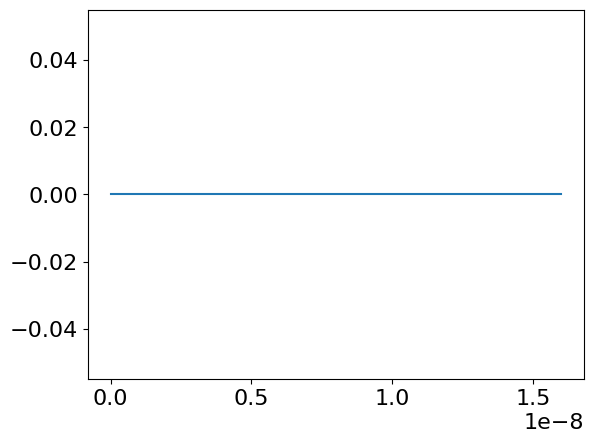

In [33]:
sig[0].draw(0,160e-10,100)

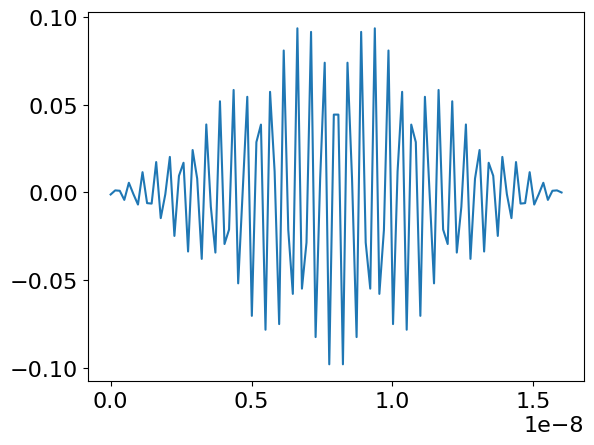

In [34]:
sig[1].draw(0,160e-10,100)

In [11]:
from qiskit_experiments.framework.composite import ParallelExperiment

In [12]:
rabi_parallel = ParallelExperiment([rabi0,rabi1],backend=pulse_backend)

In [12]:
rabi_data = rabi_parallel.run(shots=4000, meas_level=2).block_for_results()

/home/rupeshknn/projects/qc/pulse-backend-qamp22/qiskit-experiments/qiskit_experiments/framework/composite/composite_experiment.py:168: UserWarning: Component 0 RoughXSXAmplitudeCal experiment run options ['meas_return'] values ['single'] will be overridden with ParallelExperiment values [None].
  warnings.warn(
/home/rupeshknn/projects/qc/pulse-backend-qamp22/qiskit-experiments/qiskit_experiments/framework/composite/composite_experiment.py:168: UserWarning: Component 1 RoughXSXAmplitudeCal experiment run options ['meas_return'] values ['single'] will be overridden with ParallelExperiment values [None].
  warnings.warn(


Component experiment 0


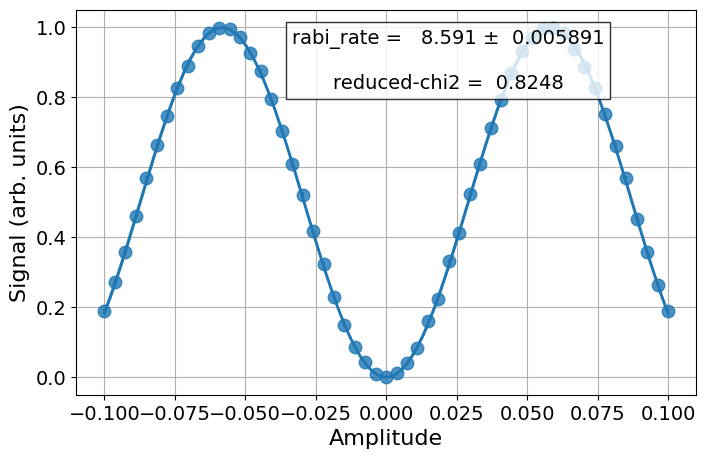

AnalysisResult
- name: @Parameters_OscillationAnalysis
- value: CurveFitResult:
 - fitting method: least_squares
 - number of sub-models: 1
  * F_cos(x) = amp * cos(2 * pi * freq * x + phase) + base
 - success: True
 - number of function evals: 10
 - degree of freedom: 51
 - chi-square: 42.06713585378439
 - reduced chi-square: 0.8248458010545959
 - Akaike info crit.: -6.743650374070981
 - Bayesian info crit.: 1.2856823668589037
 - init params:
  * amp = 0.5134091477130718
  * freq = 9.820047627230998
  * phase = 0.0
  * base = 0.5135341164708823
 - fit params:
  * amp = -0.4996368396495724 ± 0.00019901211066387727
  * freq = 8.59129502283503 ± 0.005891484785856262
  * phase = 0.002126444478862247 ± 0.0021843753820876507
  * base = 0.4998047618452245 ± 0.0001974792927216748
 - correlations:
  * (amp, base) = -0.6171481711637755
  * (amp, freq) = -0.09049517393770935
  * (phase, base) = -0.04091133155407204
  * (freq, phase) = 0.005885427661969508
  * (amp, phase) = 0.0303069049581516
  

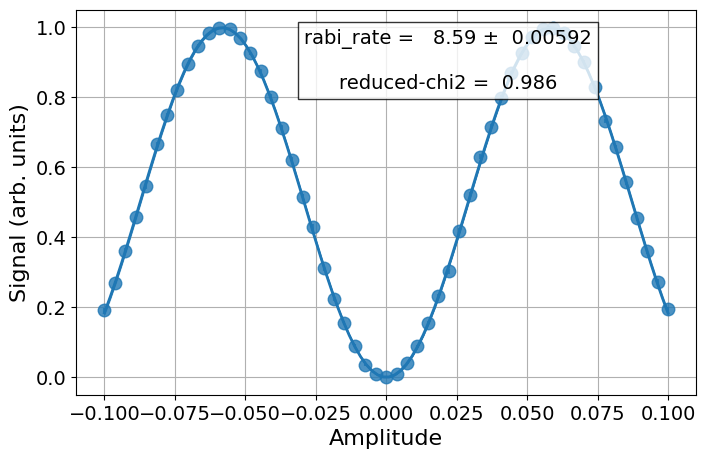

AnalysisResult
- name: @Parameters_OscillationAnalysis
- value: CurveFitResult:
 - fitting method: least_squares
 - number of sub-models: 1
  * F_cos(x) = amp * cos(2 * pi * freq * x + phase) + base
 - success: True
 - number of function evals: 9
 - degree of freedom: 51
 - chi-square: 50.287865263313364
 - reduced chi-square: 0.9860365737904582
 - Akaike info crit.: 3.0736838535005804
 - Bayesian info crit.: 11.103016594430464
 - init params:
  * amp = 0.5108722819295176
  * freq = 9.820047627230998
  * phase = 0.7853981633974483
  * base = 0.5109972506873282
 - fit params:
  * amp = -0.49948507191885594 ± 0.00021795240145286855
  * freq = 8.589849757730036 ± 0.0059202970269003835
  * phase = 0.0003921649152542098 ± 0.0021841806850356593
  * base = 0.49962369182205 ± 0.00021609188124743667
 - correlations:
  * (amp, base) = -0.6815493710281869
  * (amp, freq) = -0.09888786304281802
  * (freq, phase) = -0.003963298486108104
  * (amp, phase) = -0.0006410585402101466
  * (phase, base) = 

In [13]:
for i, sub_data in enumerate(rabi_data.child_data()):
    print("Component experiment",i)
    display(sub_data.figure(0))
    for result in sub_data.analysis_results():
        print(result)